# Updating the HLCA with an IPF data

In this notebook, we will update the HLCA reference tree with an IPF dataset. For this we will use the refined annotations (add link). We will also compare these refined annotations with the constructed hierarchy and the predictions we made in this notebook (add link). You can also download the predictions from Zenodo (add link)

In [2]:
import scanpy as sc
import scHPL
import numpy as np
import pickle
import time as tm
import copy as cp
import pandas as pd
import matplotlib

In [3]:
sc.settings.set_figure_params(dpi=1000, frameon=False)
sc.set_figure_params(dpi=1000)
sc.set_figure_params(figsize=(7,7))

matplotlib.rcParams['pdf.fonttype'] = 42

## Read the reference + classification tree

In [3]:
LCA = sc.read('../../LCA/HLCA_emb_and_metadata.h5ad')
file_to_read = open("../../LCA/tree_HCLA_FAISS_withRE.pickle", "rb")
HLCA_tree = pickle.load(file_to_read)
file_to_read.close()


## Load query + refined annotations

In [4]:
emb_ipf = sc.read('../../LCA/HLCA_extended_models_and_embs/surgery_output_embeddings_withpred/Sheppard_2020_emb_LCAv2.h5ad')
emb_ipf


AnnData object with n_obs × n_vars = 80020 × 30
    obs: 'scHPL_pred'

In [5]:
# Count data
data_IPF = sc.read('Sheppard_2020_noSC_finalAnno.h5ad')


/tmp/ipykernel_1692860/273965301.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_IPF.obs['scHPL_pred'] = emb_ipf.obs['scHPL_pred']


In [8]:
data_IPF.obs['anno_final'] = labels_new['anno_final']

/tmp/ipykernel_1692860/3620137671.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_IPF.obs['anno_final'] = labels_new['anno_final']


In [9]:
data_IPF.write('Sheppard_2020_noSC_finalAnno.h5ad')

## Update the hierarchy

In [10]:
data_IPF.obs['ct-batch'] = np.char.add(np.char.add(np.array(data_IPF.obs['anno_final'], dtype=str), '-'), np.array(data_IPF.obs['condition']))


In [11]:
emb_ipf = emb_ipf[data_IPF.obs_names]


In [13]:
emb_ipf.obs['ct-batch'] = data_IPF.obs['ct-batch']
emb_ipf.obs['batch'] = data_IPF.obs['condition']
emb_ipf.obs['batch2'] = 'Query'

/tmp/ipykernel_590906/4259828463.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  emb_ipf.obs['ct-batch'] = data_IPF.obs['ct-batch']


In [14]:
LCA.obs['ct-batch'] = LCA.obs['ann_finest_level']
LCA.obs['batch'] = 'Reference'
LCA.obs['batch2'] = 'Reference'

In [15]:
LCA_IPF = sc.concat([LCA, emb_ipf])
LCA_IPF

AnnData object with n_obs × n_vars = 646487 × 30
    obs: 'ct-batch', 'batch', 'batch2'

In [16]:
LCA_IPF.obs['ct-batch'] = LCA_IPF.obs['ct-batch'].str.replace('_',' ')

In [17]:
## Remove cell population smaller than 10 cells
xx = LCA_IPF.obs.groupby(['ct-batch']).count()
cp_toremove = xx[xx['batch'] < 10].index
idx_tokeep = np.isin(LCA_IPF.obs['ct-batch'], cp_toremove) == False
LCA_IPF = LCA_IPF[idx_tokeep]
LCA_IPF


View of AnnData object with n_obs × n_vars = 646445 × 30
    obs: 'ct-batch', 'batch', 'batch2'

Starting tree:


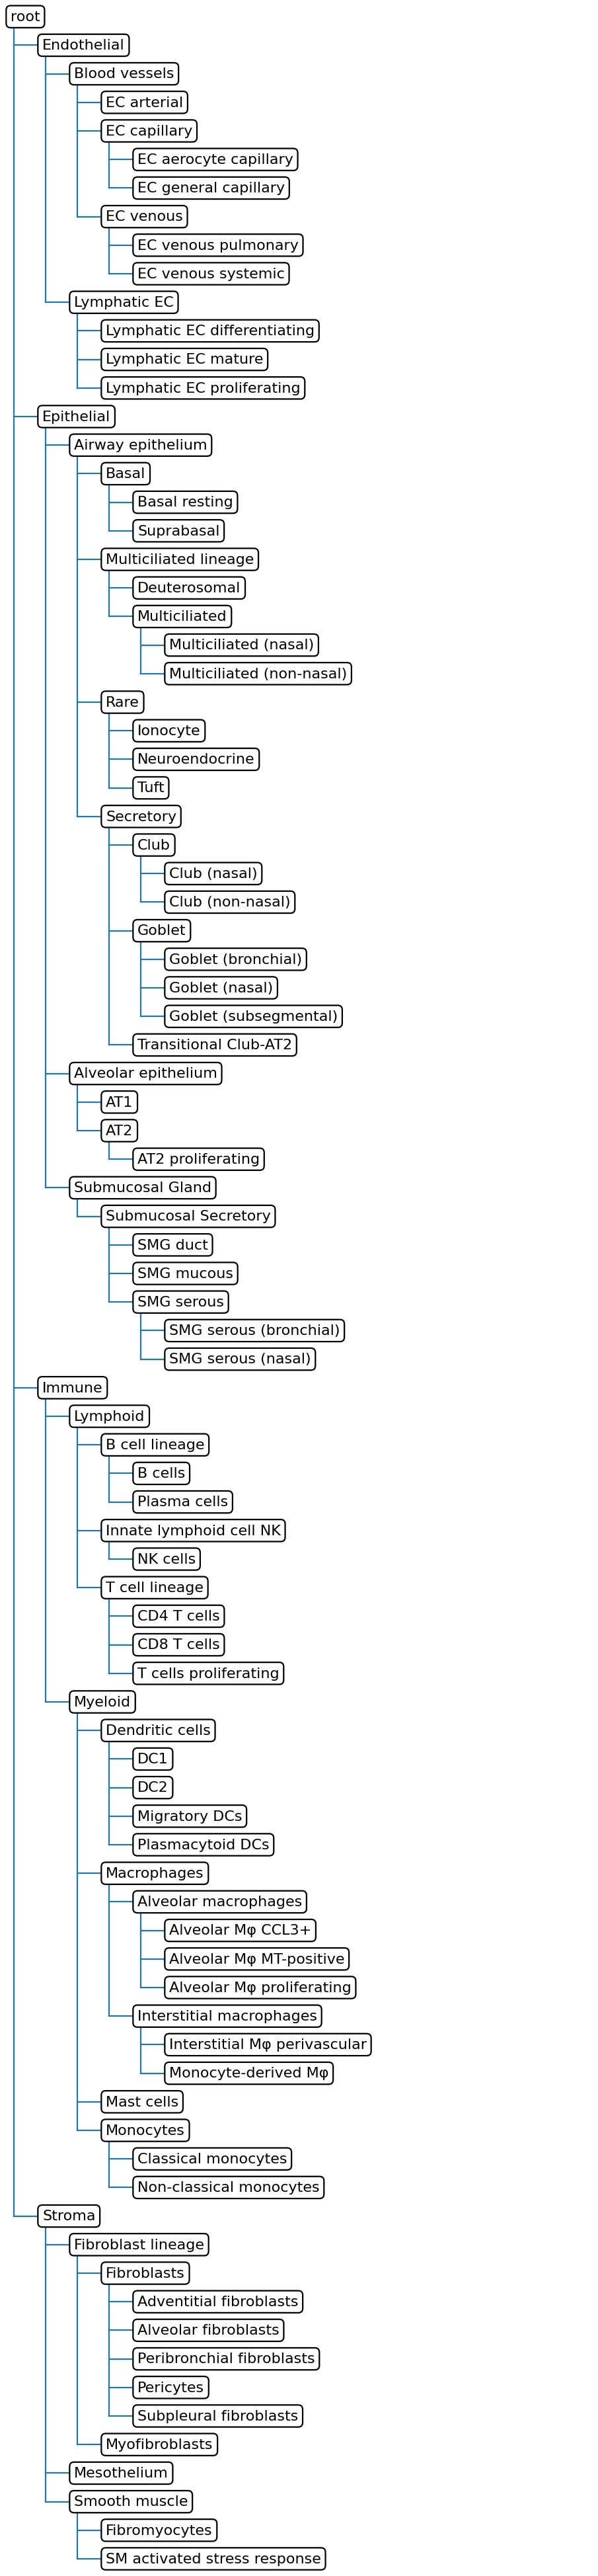


Adding dataset Query to the tree
Normalized CM
ypred                         2 Mesothelium-Healthy  2 Mesothelium-IPF  \
ytrue                                                                    
AT1                                        0.000000           0.000000   
AT2                                        0.000000           0.000000   
AT2 proliferating                          0.000000           0.000000   
Adventitial fibroblasts                    0.000000           0.000000   
Alveolar Mφ CCL3+                          0.000000           0.000000   
Alveolar Mφ MT-positive                    0.000000           0.000000   
Alveolar Mφ proliferating                  0.000000           0.000000   
Alveolar fibroblasts                       0.000000           0.000000   
Alveolar macrophages                       0.000000           0.000000   
B cells                                    0.000000           0.000000   
Basal resting                              0.000000           0.

These populations are missing from the tree: 
['2 Smooth muscle-Healthy']

Updated tree:


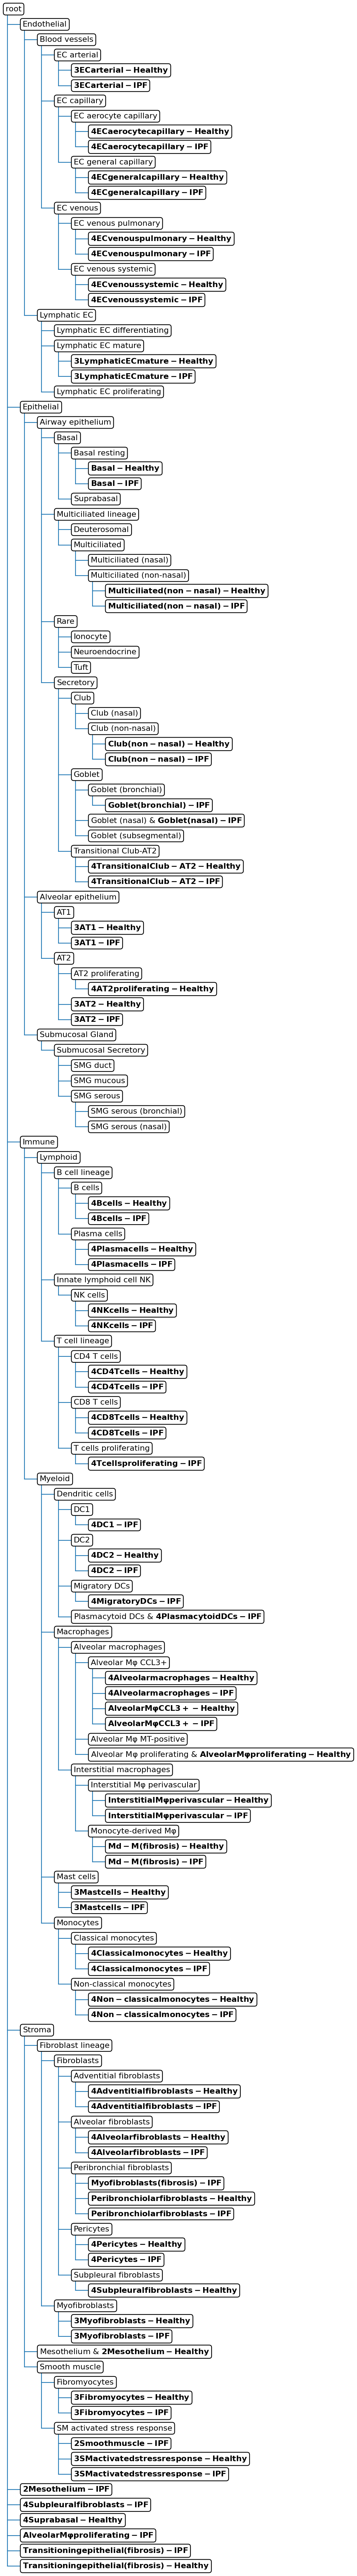

In [18]:
HLCA_tree = scHPL.learn.learn_tree(LCA_IPF, 
                                     batch_key = 'batch2',
                                     batch_order = ['Query'],
                                     cell_type_key = 'ct-batch',
                                     tree = HLCA_tree,
                                     retrain = False, useRE=True,
                                     batch_added = ['Reference'], print_conf=True
                                    )


### Look at the macrophages

In [19]:
data_LCA = sc.read_h5ad('../../LCA/local.h5ad')
data_LCA.var_names = np.asarray(data_LCA.var['feature_name'], dtype=str)

In [20]:
sc.pp.normalize_total(data_IPF)
sc.pp.log1p(data_IPF)

In [21]:
data_all = sc.concat([data_LCA, data_IPF])
data_all

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 646487 × 1897
    obs: 'sample', 'study', 'subject_ID', 'smoking_status', 'BMI', 'condition', 'sample_type', 'dataset', 'age', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'sex', 'ethnicity'
    obsm: 'X_scanvi_emb'

In [22]:
data_all.obs['ann_level_3'] = data_LCA.obs.ann_level_3
data_all.obs['ann_finest_level'] = data_LCA.obs.ann_finest_level
data_all.obs['anno_final'] = data_IPF.obs.anno_final
data_all.obs['scHPL_pred'] = data_IPF.obs.scHPL_pred
data_all.obs['condition'] = data_IPF.obs.condition

In [23]:
idx_macro = ((data_all.obs['ann_level_3'] == 'Macrophages') | 
             np.isin(data_all.obs.anno_final, ['4_Alveolar macrophages', 'Alveolar Mφ CCL3+',
                                               'Alveolar Mφ proliferating',
                                                'Interstitial Mφ perivascular', 'Md-M (fibrosis)']))
data_macro = data_all[idx_macro]
data_macro

View of AnnData object with n_obs × n_vars = 117425 × 1897
    obs: 'sample', 'study', 'subject_ID', 'smoking_status', 'BMI', 'condition', 'sample_type', 'dataset', 'age', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'sex', 'ethnicity', 'ann_level_3', 'ann_finest_level', 'anno_final', 'scHPL_pred'
    obsm: 'X_scanvi_emb'

#### Sankey diagram

Rename the different kind of rejected cells all to 'Rejected' 

In [28]:
idx_rej = ((data_macro.obs['scHPL_pred'] == 'Rejection (dist)') | (data_macro.obs['scHPL_pred'] == 'Rejected (RE)'))
data_macro.obs['scHPL_pred'] = data_macro.obs['scHPL_pred'].cat.add_categories('Rejected')
data_macro.obs['scHPL_pred'].values[idx_rej] = 'Rejected'

/tmp/ipykernel_590906/617128616.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_macro.obs['scHPL_pred'] = data_macro.obs['scHPL_pred'].cat.add_categories('Rejected')


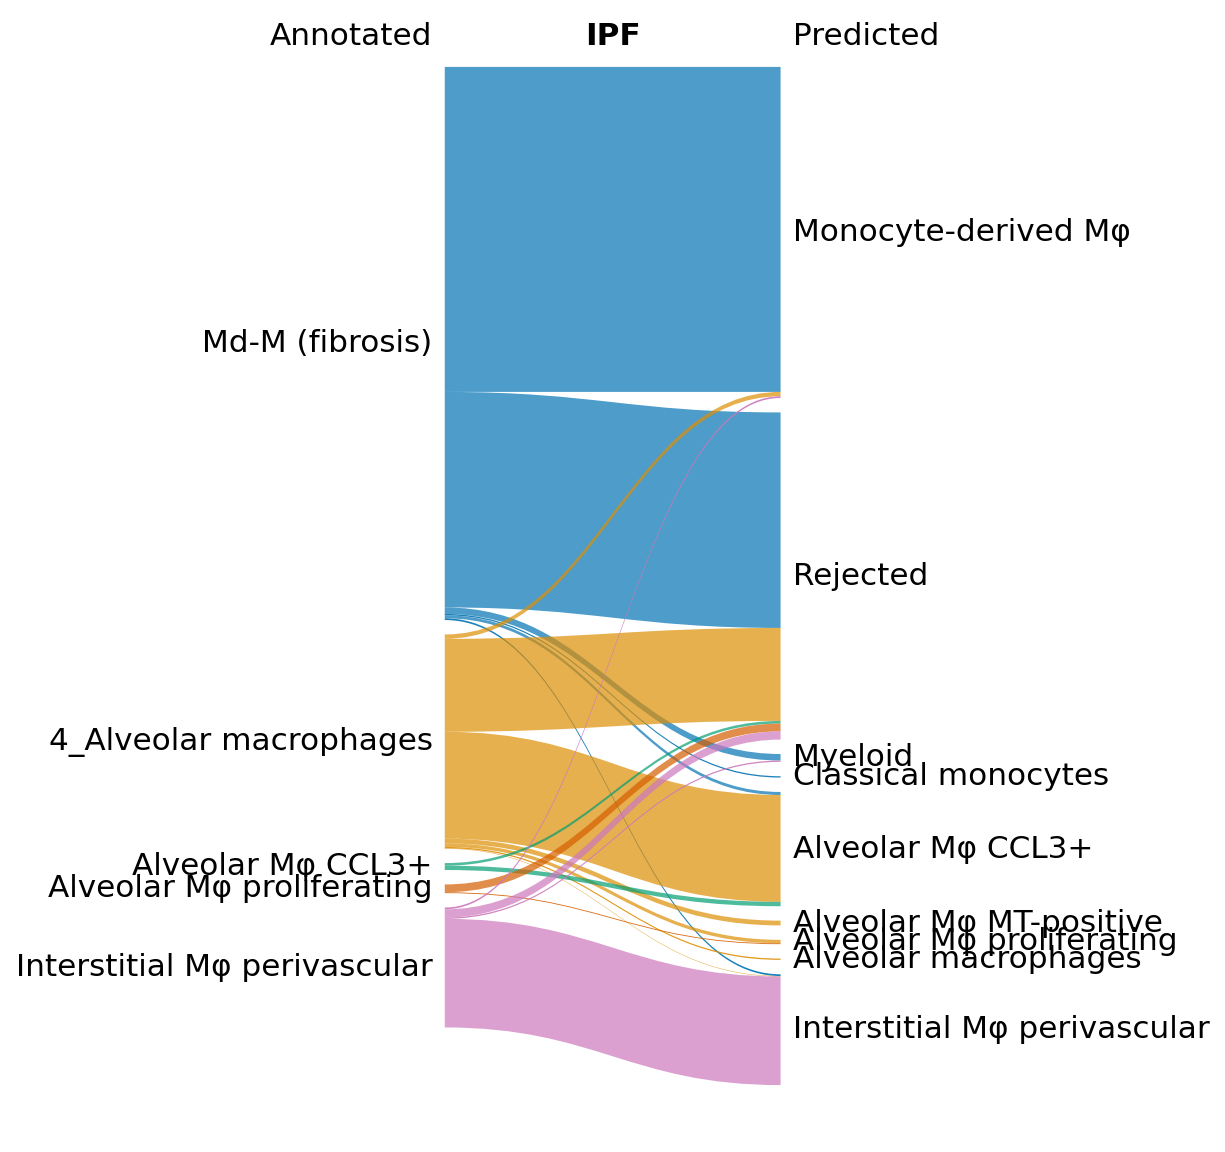

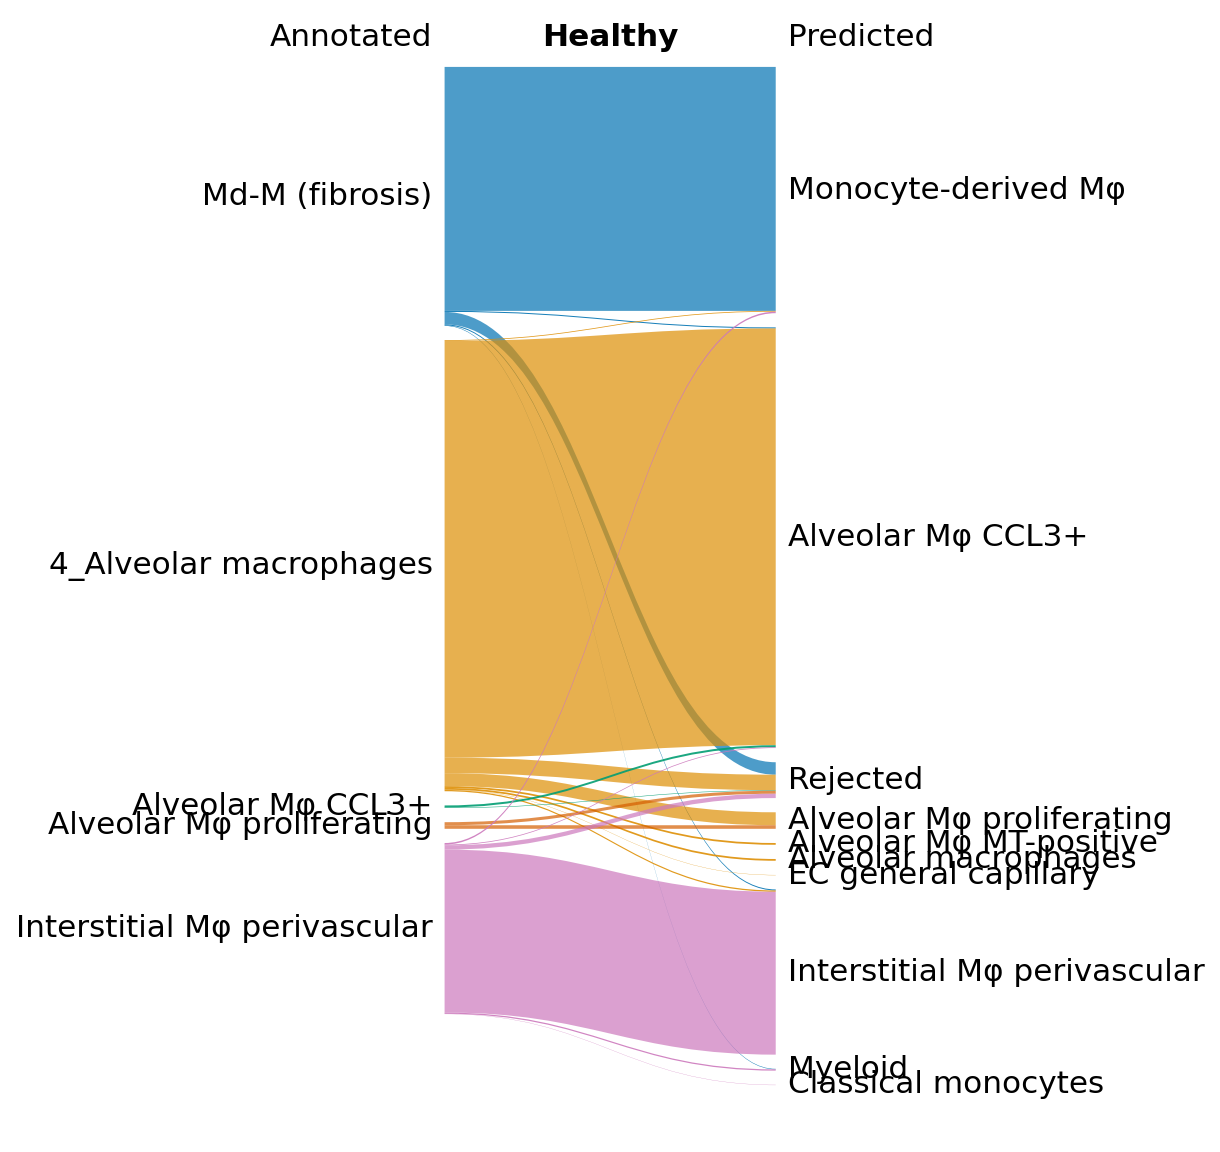

In [29]:
import sankey

idx1 = (data_macro.obs.study == 'Sheppard_2020') & (data_macro.obs.condition == 'IPF')
idx2 = (data_macro.obs.study == 'Sheppard_2020') & (data_macro.obs.condition == 'Healthy')

x = sankey.sankey( data_macro.obs['anno_final'][idx1],
                  data_macro.obs['scHPL_pred'][idx1], save=True, 
                  name_file='sankey_IPF', title="IPF", title_left="Annotated",
                  title_right="Predicted", alpha=0.7,
                  left_order=['Md-M (fibrosis)',
                             '4_Alveolar macrophages',
                              'Alveolar Mφ CCL3+',
                              'Alveolar Mφ MT-positive',
                              'Alveolar Mφ proliferating',
                              'Interstitial Mφ perivascular'
                             ], fontsize='medium')

x = sankey.sankey( data_macro.obs['anno_final'][idx2],
                  data_macro.obs['scHPL_pred'][idx2], save=True, 
                  name_file='sankey_NML', title="Healthy", title_left="Annotated",
                  title_right="Predicted", alpha=0.7,
                  left_order=['Md-M (fibrosis)',
                             '4_Alveolar macrophages',
                              'Alveolar Mφ CCL3+',
                              'Alveolar Mφ MT-positive',
                              'Alveolar Mφ proliferating',
                              'Interstitial Mφ perivascular'
                             ], fontsize='medium')

#### Differentially expressed genes between rej. and not rej. cells

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


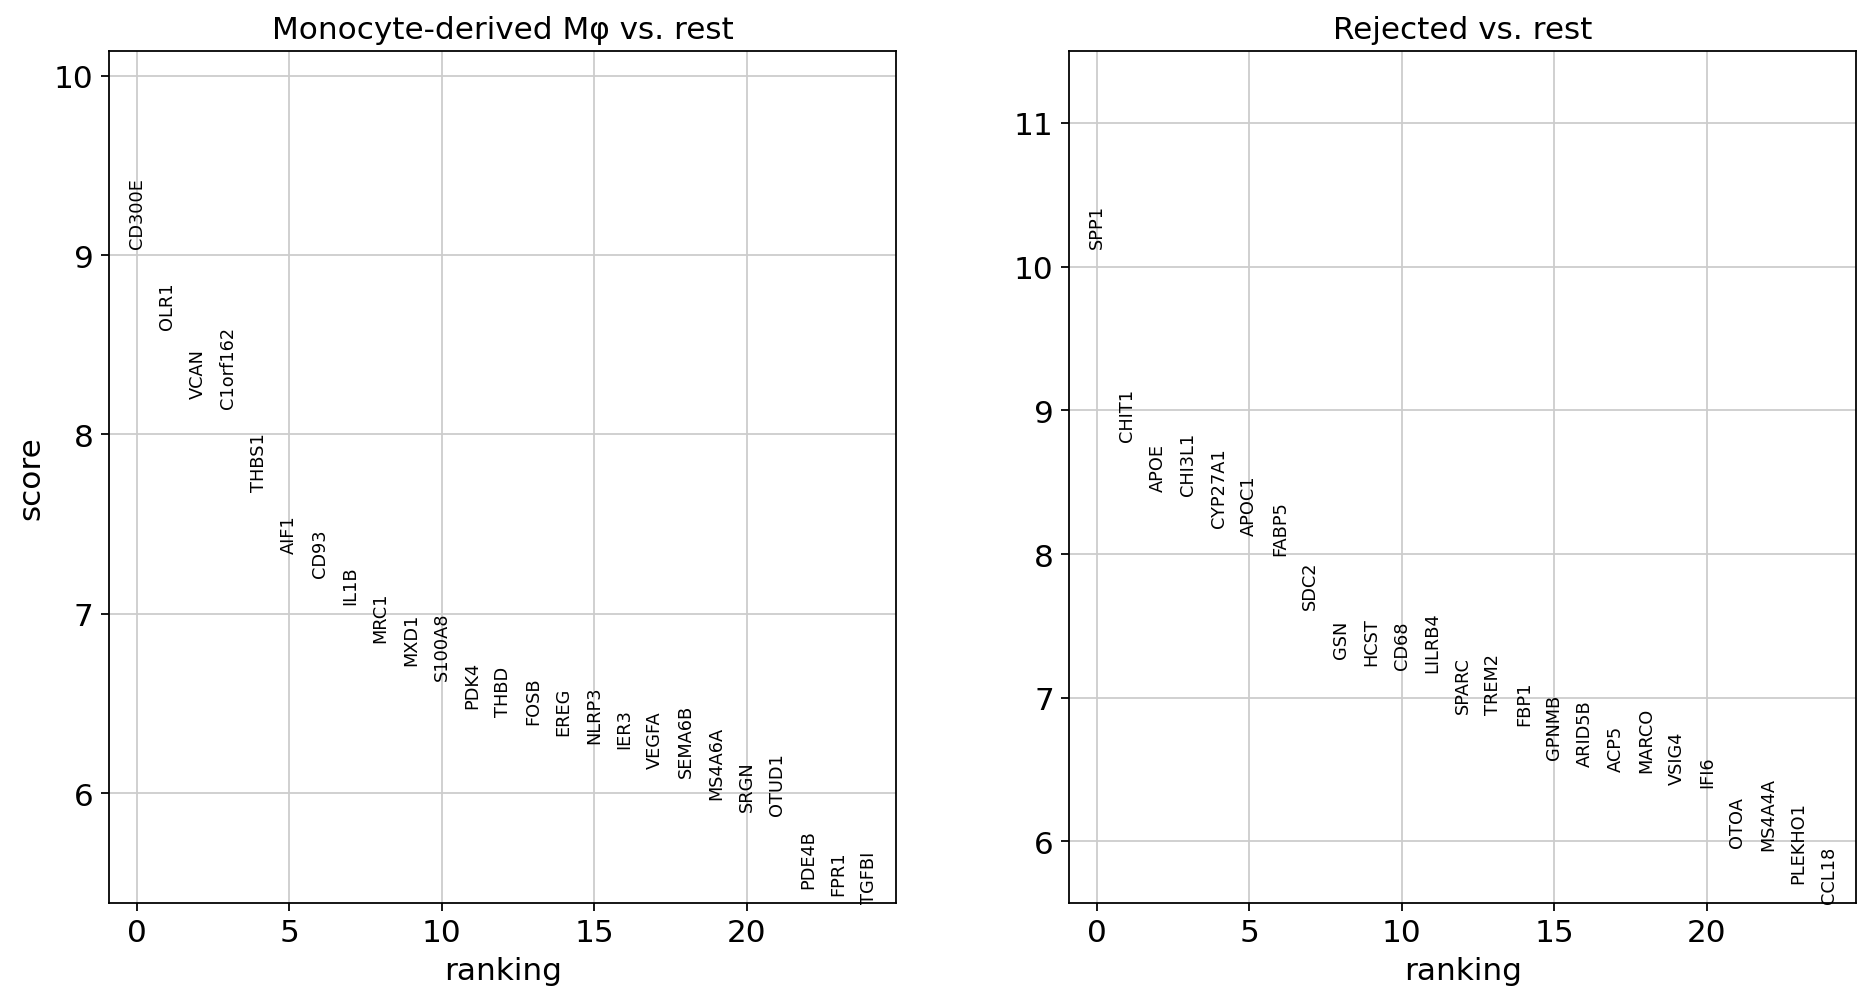

In [30]:
### Do DE
# Group 1: anno_final = Md-M (fibrosis), scHPL_pred = Monocyte-derived macro, condition=IPF
# Group 2: anno_final = Md-M (fibrosis), scHPL_pred = Rejected, condition=IPF
MdM = (data_macro.obs.condition == 'IPF') & (data_macro.obs.anno_final == 'Md-M (fibrosis)') & ((data_macro.obs.scHPL_pred == 'Rejected') | (data_macro.obs.scHPL_pred == 'Monocyte-derived Mφ'))
data_MdM = data_macro[MdM]

sc.pp.normalize_total(data_MdM)
sc.pp.log1p(data_MdM)

sc.tl.rank_genes_groups(data_MdM, 'scHPL_pred', method='t-test')
sc.pl.rank_genes_groups(data_MdM, n_genes=25, sharey=False)


So now we see that 'SPP1' is the #1 upregulated gene in the rejected cells. Now, we will visualize the expression of this gene in the other macrophage populations of the reference and query. This will show that indeed this gene is only expressed in the rejected population and this is thus indeed looks like a new subpopulation.

In [31]:
data_macro.obs['ann_toplot'] = np.char.add(np.array(data_macro.obs.ann_finest_level, dtype=str),'-Reference')
data_macro.obs.ann_toplot[data_macro.obs.study == 'Sheppard_2020'] = np.char.add(np.char.add(np.array(data_macro.obs.anno_final, dtype=str), '-'), np.array(data_macro.obs.condition, dtype=str))
idx = (data_macro.obs.ann_toplot == 'Md-M (fibrosis)-IPF') & (data_macro.obs.scHPL_pred == 'Rejected')
data_macro.obs['ann_toplot'][idx] = 'Md-M (fibrosis)-IPF-(Rejected)'

/tmp/ipykernel_590906/559716464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_macro.obs.ann_toplot[data_macro.obs.study == 'Sheppard_2020'] = np.char.add(np.char.add(np.array(data_macro.obs.anno_final, dtype=str), '-'), np.array(data_macro.obs.condition, dtype=str))
/tmp/ipykernel_590906/559716464.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_macro.obs['ann_toplot'][idx] = 'Md-M (fibrosis)-IPF-(Rejected)'


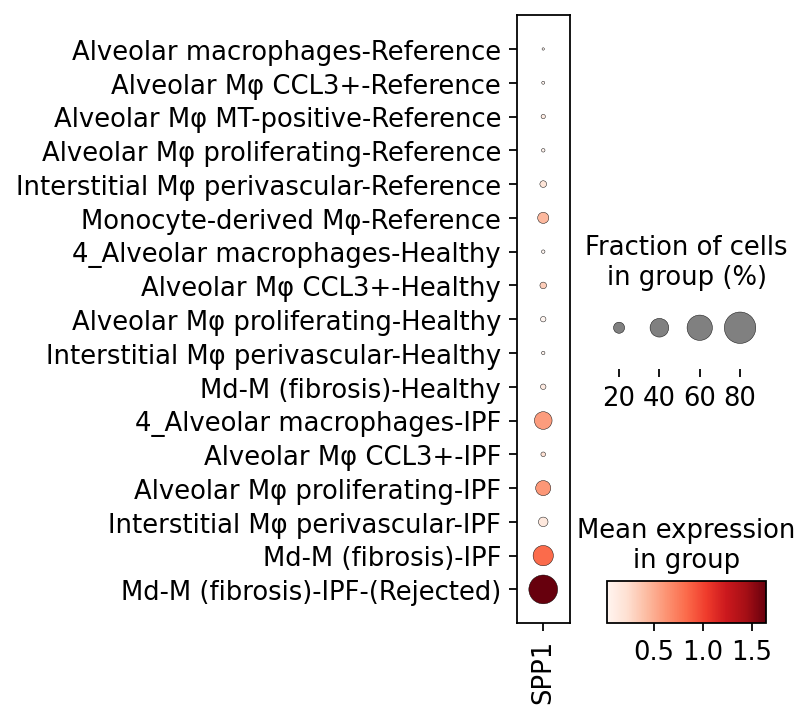

In [32]:
sc.pl.dotplot(data_macro, ['SPP1'], groupby='ann_toplot',
             categories_order=[
                 'Alveolar macrophages-Reference',
                 'Alveolar Mφ CCL3+-Reference',
                 'Alveolar Mφ MT-positive-Reference',
                 'Alveolar Mφ proliferating-Reference',
                 'Interstitial Mφ perivascular-Reference',
                 'Monocyte-derived Mφ-Reference',
                 
                 '4_Alveolar macrophages-Healthy',
                 'Alveolar Mφ CCL3+-Healthy', 
                 'Alveolar Mφ proliferating-Healthy',
                 'Interstitial Mφ perivascular-Healthy',
                 'Md-M (fibrosis)-Healthy',
                 
                 '4_Alveolar macrophages-IPF',
                 'Alveolar Mφ CCL3+-IPF',
                 'Alveolar Mφ proliferating-IPF',
                 'Interstitial Mφ perivascular-IPF',
                 'Md-M (fibrosis)-IPF',
                 'Md-M (fibrosis)-IPF-(Rejected)'
             ], figsize=(2,5), save='_IPF_SPP1.pdf')
